In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor

import math


In [0]:
#dataset loading
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [0]:

class GRUCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()

    #normalization
    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x) 
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        resetgate = torch.sigmoid(i_r + h_r)
        inputgate = torch.sigmoid(i_i + h_i)
        newgate = torch.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        
        
        return hy

In [0]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
         
       
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        
        
        self.fc = nn.Linear(hidden_dim, output_dim)
     
    
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
         
        outs = []
        
        hn = h0[0,:,:]
        
        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:,seq,:], hn) 
            outs.append(hn)
            

        out = outs[-1].squeeze()
        
        out = self.fc(out) 
        return out

In [0]:
#init model
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10
 
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)
     
#add cross-entropy loss
criterion = nn.CrossEntropyLoss()
 
#add sgd optimizer
learning_rate = 0.1
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [0]:
#train model
 
# Number of steps to unroll
seq_dim = 28 

for epoch in range(5):
    for i, (images, labels) in enumerate(train_loader):         
        images = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
          
        # Clear gradients
        optimizer.zero_grad()
         
        #forward pass
        outputs = model(images)

        #calc loss
        loss = criterion(outputs, labels)

        # Getting gradients
        loss.backward()

        # Updating parameters
        optimizer.step()

Predicted result is: 7, target result is: 7
accuracy on testset 98%


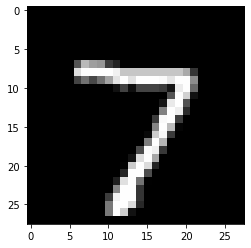

In [184]:
#show prediction of this ine image
to_predict = 0
#check accuracy on testset
correct = 0
total = 0
for images, labels in test_loader:
  images = Variable(images.view(-1 , seq_dim, input_dim))
  out = model(images)
  _, predicted = torch.max(out.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum()
  print('Predicted result is: %s, target result is: %s' % (predicted.numpy()[to_predict], labels.numpy()[to_predict]))
  plt.imshow(images[to_predict], cmap=plt.get_cmap('gray'))
  break

accuracy = 100 * correct / total
print('accuracy on testset {}%'.format(accuracy))
